In [14]:
import pandas as pd
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
PROD_PATH = "../data/PROCESSED/manhuacu.csv"

In [16]:
# LSTM Hyperparameters
LSTM_WINDOW_SIZE = 20
LSTM_HIDDEN_SIZE = 64
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = 0.2
LSTM_EPOCHS = 200

In [17]:
def get_day_of_year_index(date: datetime):
    """Convert date to day of year."""
    return datetime(date.year, date.month, date.day).timetuple().tm_yday - 1


def get_sin_cos(x: float):
    """Convert x to sin and cos."""
    rad = 2 * np.pi * x
    return (np.sin(rad), np.cos(rad))


def encode_date(date: datetime):
    is_leap_year = 1 if date.year % 4 == 0 else 0
    total_year_days = 366 if is_leap_year else 365

    day_index = get_day_of_year_index(date)
    
    frac = day_index / total_year_days
    return get_sin_cos(frac)

# Test
print("Encoding date 2020-01-01")
print(encode_date(datetime(2020, 1, 1)))  # (0.0, 1.0)
print("\n")
print("Encoding date 2020-06-01")
print(encode_date(datetime(2020, 6, 1)))  # (0.5, 0.0)
print("\n")
print("Encoding date 2020-12-31")
print(encode_date(datetime(2020, 12, 31)))  # (0.9999999999999999, 1.0)
print("\n")

Encoding date 2020-01-01
(np.float64(0.0), np.float64(1.0))


Encoding date 2020-06-01
(np.float64(0.5074150932938454), np.float64(-0.8617017599480682))


Encoding date 2020-12-31
(np.float64(-0.017166329754707492), np.float64(0.9998526477050269))




## 1. Load Data

In [18]:
NDVI = pd.read_csv(NDVI_PATH)
NDVI

,Data,NDVI,Year
0,2000-02-18,0.4925,2000
1,2000-03-05,0.7898,2000
2,2000-03-21,0.8125,2000
3,2000-04-06,0.7585,2000
4,2000-04-22,0.7437,2000
...,...,...,...
573,2025-01-17,0.8477,2025
574,2025-02-02,0.8119,2025
575,2025-02-18,0.8513,2025
576,2025-03-06,0.8480,2025


In [19]:

NDVI["N_Observations"] = NDVI.groupby("Year")["Data"].transform("count")

NDVI[["Date_sin", "Date_cos"]] = NDVI["Data"].apply(
    lambda x: pd.Series(encode_date(datetime.strptime(x, "%Y-%m-%d")))
)

# Assert order by Data (ascending)
NDVI = NDVI.sort_values(by="Data", ascending=True)

NDVI = NDVI[(NDVI["Year"] >= 2000) & (NDVI["Year"] <= 2024)]

NDVI

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos
0,2000-02-18,0.4925,2000,20,0.733885,0.679273
1,2000-03-05,0.7898,2000,20,0.890617,0.454755
2,2000-03-21,0.8125,2000,20,0.980575,0.196143
3,2000-04-06,0.7585,2000,20,0.997018,-0.077175
4,2000-04-22,0.7437,2000,20,0.938710,-0.344707
...,...,...,...,...,...,...
567,2024-10-15,0.6692,2024,23,-0.973264,0.229688
568,2024-10-31,0.7183,2024,23,-0.874481,0.485060
569,2024-11-16,0.7387,2024,23,-0.710135,0.704066
570,2024-12-02,0.7552,2024,23,-0.492548,0.870285


In [20]:
PROD = pd.read_csv(PROD_PATH)
PROD = PROD[(PROD["Year"] >= 2000) & (PROD["Year"] <= 2024)]
max_productivity = PROD["Productivity (kg/ha)"].max()
PROD["Normalized_productivity"] = PROD["Productivity (kg/ha)"] / max_productivity
PROD

,Year,Production (kg),Area (ha),Productivity (kg/ha),Normalized_productivity
26,2000,17424000,13200,1320.000000,0.785706
27,2001,17424000,13200,1320.000000,0.785706
28,2002,26325000,17550,1500.000000,0.892847
29,2003,13533000,17350,780.000000,0.464281
30,2004,16560000,17250,960.000000,0.571422
31,2005,16065000,17850,900.000000,0.535708
32,2006,16065000,17850,900.000000,0.535708
33,2007,16065000,17850,900.000000,0.535708
34,2008,23958000,18150,1320.000000,0.785706
35,2009,20235000,17750,1140.000000,0.678564


## 2. Prepare Data

In [21]:
NDVI_last_20_per_year = NDVI.groupby("Year").tail(20)
NDVI_last_20_per_year

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos
0,2000-02-18,0.4925,2000,20,0.733885,0.679273
1,2000-03-05,0.7898,2000,20,0.890617,0.454755
2,2000-03-21,0.8125,2000,20,0.980575,0.196143
3,2000-04-06,0.7585,2000,20,0.997018,-0.077175
4,2000-04-22,0.7437,2000,20,0.938710,-0.344707
...,...,...,...,...,...,...
567,2024-10-15,0.6692,2024,23,-0.973264,0.229688
568,2024-10-31,0.7183,2024,23,-0.874481,0.485060
569,2024-11-16,0.7387,2024,23,-0.710135,0.704066
570,2024-12-02,0.7552,2024,23,-0.492548,0.870285


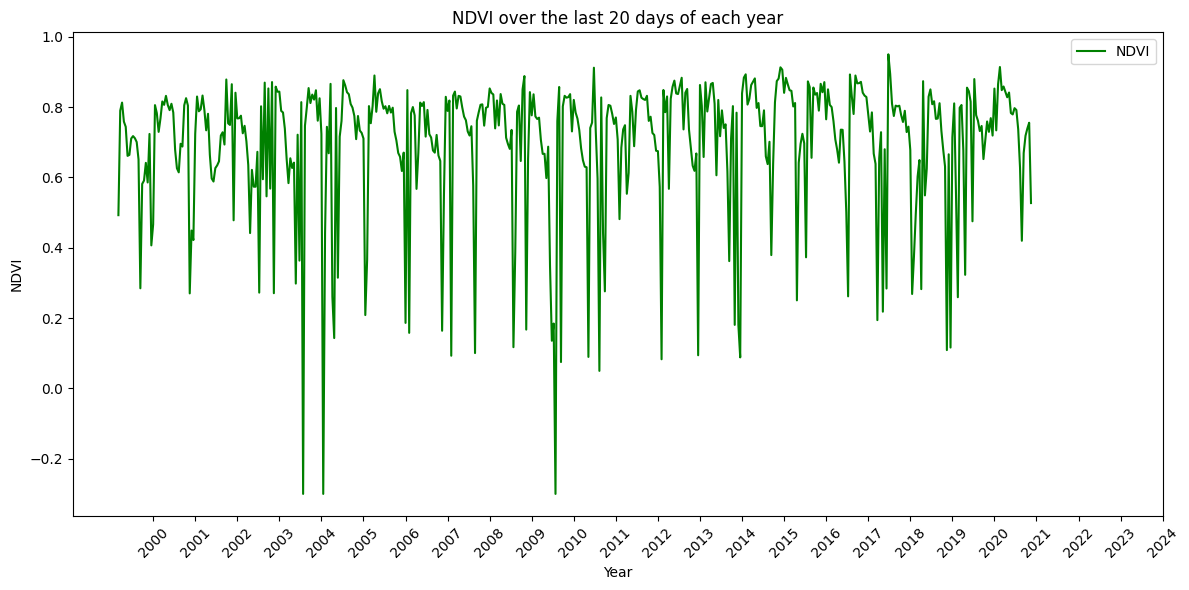

In [22]:
# Plotting NDVI
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    NDVI_last_20_per_year["Data"],
    NDVI_last_20_per_year["NDVI"],
    label="NDVI",
    color="green",
)
plt.title("NDVI over the last 20 days of each year")

plt.xlabel("Year")
plt.xticks(
    ticks=NDVI_last_20_per_year.groupby("Year").tail(1).index,
    labels=NDVI_last_20_per_year.groupby("Year").tail(1)["Year"],
)
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
class MLPDataset(torch.utils.data.Dataset):
    def __init__(self, ndvi_df, prod_df):
        self.ndvi_df = ndvi_df
        self.prod_df = prod_df

    def __len__(self):
        return self.ndvi_df["Year"].nunique()

    def __getitem__(self, idx):
        years = self.ndvi_df["Year"].sort_values().unique()
        if idx >= len(years):
            raise IndexError("Index out of range")
        year = years[idx]
        ndvi = self.ndvi_df[self.ndvi_df["Year"] == year]["NDVI"].values
        prod = self.prod_df[self.prod_df["Year"] == year][
            "Productivity (kg/ha)"
        ].values[0]
        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )


dataset = MLPDataset(NDVI_last_20_per_year, PROD)
dataset[0]

train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dateset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size, test_size]
)

## 3. Model training

### 3.1. Multi-layer Perceptron

Essa rede é uma feedforward perceptron multi-layer comum (1 camada interna).

As entradas são os 20 últimos NDVIs do ano, a saída é a produtividade prevista (kg/ha).

In [24]:
mlp_network = nn.Sequential(
    nn.Linear(20, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
)
mlp_network = mlp_network.to(device)
optimizer = optim.Adam(mlp_network.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = []
best_loss = float("inf")
for i in range(100):
    mlp_network.train()
    for ndvi, prod in train_dataset:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        pred = mlp_network(ndvi)
        loss = loss_fn(pred, torch.tensor([prod], device=device))
        loss.backward()
        optimizer.step()
    
    epoch_losses = []
    mlp_network.eval()
    with torch.no_grad():
        for ndvi, prod in valid_dateset:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = mlp_network(ndvi)
            loss = loss_fn(pred, torch.tensor([prod], device=device))
            epoch_losses.append(loss.item())
            
        if np.mean(epoch_losses) < best_loss:
            best_loss = np.mean(epoch_losses)
            torch.save(mlp_network.state_dict(), "mlp.pth")
            print(f"Saving MLP model\tepoch: {i+1}\tvalidation loss: {best_loss:.4f}")
    
    losses.append(np.mean(epoch_losses))

Saving MLP model	epoch: 1	validation loss: 1617456.3750
Saving MLP model	epoch: 2	validation loss: 286716.6094
Saving MLP model	epoch: 3	validation loss: 7901.5215


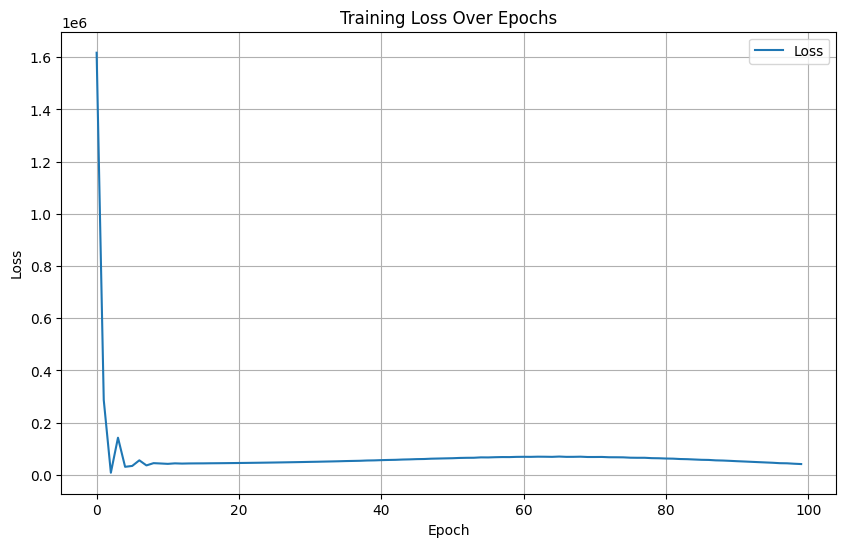

In [25]:
def plot_training_loss(losses):
    """
    Plots the training loss over epochs.

    Args:
        losses (list): List of loss values for each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_training_loss(losses)

### 3.2. LSTM

In [26]:
class LSTMDataset(torch.utils.data.Dataset):
    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df
        self.prod_df = prod_df
        self.window_size = window_size

    def __len__(self):
        return len(self.ndvi_df) - self.window_size

    def __getitem__(self, idx):
        ndvi = self.ndvi_df.iloc[idx : idx + self.window_size][
            ["NDVI", "Date_sin", "Date_cos"]
        ].values

        year = self.ndvi_df.iloc[idx + self.window_size]["Year"]
        prod = self.prod_df[self.prod_df["Year"] == year][
            "Productivity (kg/ha)"
        ].values[0]

        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )



In [27]:
# Test Dataset
dataset = LSTMDataset(NDVI_last_20_per_year, PROD, LSTM_WINDOW_SIZE)

train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
valid_dateset = torch.utils.data.Subset(
    dataset, range(train_size, train_size + valid_size)
)
test_dataset = torch.utils.data.Subset(
    dataset, range(train_size + valid_size, train_size + valid_size + test_size)
)

In [28]:
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define model with Linear layer
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=LSTM_DROPOUT
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x, hidden_n=None, hidden_c=None):
        if hidden_n is None or hidden_c is None:
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :])  # Get output of last time step
        else:
            out, (hidden_n, hidden_c) = self.lstm(x, (hidden_n, hidden_c))
            out = self.fc(out[:, -1, :])  # Get output of last time step
            return out, (hidden_n, hidden_c)


lstm_model = LSTMRegressor(
    input_size=3, hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS
).to(device)
optimizer = optim.Adam(lstm_model.parameters())
loss_fn = nn.MSELoss()

lstm_losses = []
best_loss = float("inf")
saved_epoch = 0


for i in range(LSTM_EPOCHS):
    h_n = torch.zeros(LSTM_NUM_LAYERS, 1, LSTM_HIDDEN_SIZE).to(device)  # Hidden state
    h_c = torch.zeros(LSTM_NUM_LAYERS, 1, LSTM_HIDDEN_SIZE).to(device)  # Cell state

    lstm_model.train()
    for ndvi, prod in train_dataset:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()

        pred, (h_n, h_c) = lstm_model(
            ndvi.unsqueeze(0), h_n.detach(), h_c.detach()
        )  # Add batch dimension: [1, seq_len, 3]
        # print(pred.shape)
        last_pred = pred[:, -1]  # Get the last prediction
        # print(last_pred.shape)
        loss = loss_fn(last_pred, prod.unsqueeze(0))  # Match shape: [1]
        loss.backward()
        optimizer.step()

    epoch_losses = []
    lstm_model.eval()
    with torch.no_grad():
        for ndvi, prod in valid_dateset:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = lstm_model(ndvi.unsqueeze(0))
            last_pred = pred[:, -1]  # Get the last prediction
            loss = loss_fn(last_pred, prod.unsqueeze(0))
            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        if avg_loss < best_loss:
            best_loss = avg_loss
            saved_epoch = i + 1
            torch.save(lstm_model.state_dict(), "lstm.pth")

    # if (i) % 10 == 0:
    print(f"Epoch {i+1}/{LSTM_EPOCHS} - Loss: {avg_loss:.4f}")
    lstm_losses.append(avg_loss)

print(f"\n\nSaved LSTM model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

Epoch 1/200 - Loss: 1716142.9635
Epoch 2/200 - Loss: 1653215.5990
Epoch 3/200 - Loss: 1593440.5781
Epoch 4/200 - Loss: 1535755.7135
Epoch 5/200 - Loss: 1479820.8750
Epoch 6/200 - Loss: 1425460.0677
Epoch 7/200 - Loss: 1372561.8490
Epoch 8/200 - Loss: 1321048.5911
Epoch 9/200 - Loss: 1270863.7656
Epoch 10/200 - Loss: 1221964.4193
Epoch 11/200 - Loss: 1174317.8385
Epoch 12/200 - Loss: 1127899.2917
Epoch 13/200 - Loss: 1082688.8099
Epoch 14/200 - Loss: 1038672.3698
Epoch 15/200 - Loss: 995836.2370
Epoch 16/200 - Loss: 954172.5625
Epoch 17/200 - Loss: 913671.7383
Epoch 18/200 - Loss: 874328.3268
Epoch 19/200 - Loss: 836136.6549
Epoch 20/200 - Loss: 799090.0312
Epoch 21/200 - Loss: 763185.5755
Epoch 22/200 - Loss: 728416.5820
Epoch 23/200 - Loss: 694779.3112
Epoch 24/200 - Loss: 662269.1719
Epoch 25/200 - Loss: 630880.8880
Epoch 26/200 - Loss: 600609.5111
Epoch 27/200 - Loss: 571449.3646
Epoch 28/200 - Loss: 543395.8792
Epoch 29/200 - Loss: 516440.9674
Epoch 30/200 - Loss: 490578.8392
Epoch

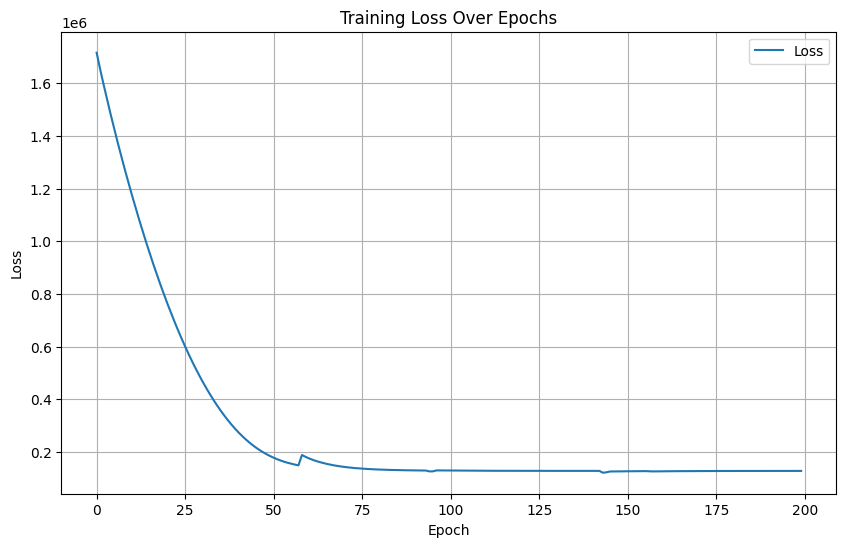

In [29]:
plot_training_loss(lstm_losses)